# Assignment 1 : natural language processing : sentiment analysis <br>
Execution time : 15 mins

In [1]:
import json as j
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import string
import nltk
from nltk.sentiment.util import mark_negation
np.random.seed(123)

In this project we will perform sentiment analysis using the dataset of amazon reviews.<br> 
The sentiment classifications are the different scores a reviewer can give ranging from 0 to 5.<br> 
Since it is generally agreed that being pretty is important, we are going to use the beauty dataset to find the best products. <br> 
This can be changed easily by downloading another dataset from : http://jmcauley.ucsd.edu/data/amazon/

In [2]:
#define settings
data = pd.read_json('/home/jasper/Documents/master/nlp/amazon/data/Beauty_5.json', lines=True)
toStem = False #use stemmer or not
toLem = True  #use lemmatizer or not
words = set(stopwords.words('english')) #remove stopwords or [] to do nothing
discretizeLabels = True  #discretize labels to 3 or not
K_best_features = 10000  # amaount of features selected from n_grams
max_review_amount = 20000 # max amount of reviews per classification for balancing
N_grams = [1,2,3,4,5]  # n_grams to test
if discretizeLabels:
    numberOfLabels = 3
else: 
    numberOfLabels = 5
    

Below we will write the preprocessing that happens to the text. <br> 
(optionally) Use stemmer : this normalises different variations of a word such as product and products.<br> 
(optionally) Use lemmatizer : this normalises different variations of a word such as better and good.<br> 
(optionally) Removing stopwords, these are all words recognised to contain very little information.<br> 
Mark negations in sentences, this processed sentences such as "I don't like it." to "I don't NEG_like NEG_it." 

In [3]:
lemmanizer = nltk.stem.WordNetLemmatizer()
stemmerize = nltk.stem.porter.PorterStemmer()

def convertToTokens(text):
    text =  " ".join(nltk.sentiment.util.mark_negation(t) for t in nltk.sent_tokenize(text))
    text = text.replace(',', ' ')
    text = text.replace('/', ' ')
    text = text.replace('(', ' ')
    text = text.replace(')', ' ')
    text = text.replace('.', ' ')
    tokens = nltk.word_tokenize(text.lower())
    #tokens = [nltk.sentiment.util.mark_negation(t) for t in tokens]
    tokens = [t for t in tokens if t not in words]
    if toLem:
        tokens = [lemmanizer.lemmatize(word) for word in tokens]
    if toStem:
        tokens = [stemmerize.stem(word) for word in tokens]
    return " ".join(str(x) for x in tokens)

(optionally) We discretize the classifications as follows:<br> 
a score of 1 or 2 -> negative (1)<br> 
a score of 3      -> neutral  (2)<br> 
a score of 4 or 5 -> positive (3)<br> 

We also balance the dataset to contain <=max_review_amount for each label 

In [4]:
reviews = []
overall = []
review_to_data_index = []
amounts = np.zeros(numberOfLabels)
for i, score in enumerate(data["overall"]):
    if score == 3 and discretizeLabels :
        score=2
    elif score <= 2 and discretizeLabels:
        score=1
    elif score >= 4 and discretizeLabels:
        score=3
    review = data["reviewText"][i]
    if amounts[score-1] < max_review_amount:
        amounts[score-1] += 1
        reviews.append(review)
        overall.append(score)
print(amounts)

[20000. 20000. 20000.]


We spilt the training set to 80% training and 20% test set and tokenize every review.
The original reviews are also kept in memory to later access when evaluating misclassifications

In [5]:
from sklearn.model_selection import train_test_split

X_train_, X_test_, y_train, y_test = train_test_split(reviews, overall, test_size=0.2)
X_train = [convertToTokens(review) for review in X_train_]
X_test = [convertToTokens(review) for review in X_test_]


we define code to evaluate results

In [6]:
from sklearn.metrics import classification_report , confusion_matrix
#Prints out the confusion matrix aswell as precision recall and F-score for each class
def printResult(y_test,X_test, model):
    print("accuracy score: " + str(model.score(X_test, y_test)))
    print(classification_report(y_test, model.predict(X_test)))
    print(confusion_matrix(y_test, model.predict(X_test)))
#prints the top features for each classification chosen by CHI2 correlation meassure    
def printTopResults(model):
    vectorizer = model.named_steps['vect']
    chi = model.named_steps['chi']
    clf = model.named_steps['clf']
    feature_names = vectorizer.get_feature_names()
    feature_names = [feature_names[i] for i in chi.get_support(indices=True)]
    feature_names = np.asarray(feature_names)
    if discretizeLabels:
        target_names = ['1', '2', '3']
    else:
        target_names = ['1', '2', '3','4','5']
    print("top 10 keywords per class:")
    for i, label in enumerate(target_names):
        top10 = np.argsort(clf.coef_[i])[-10:]
        print("%s: %s" % (label, " | ".join(feature_names[top10])))

# Feature extraction <br> 
After preprocessing the data we define the feature extraction, for this we will use TfidfVectorizer. <br>
This first computes the n_grams and converts the input text to count vectors. <br>
Then it performs TfidfTransformer which vectorizes the count vector, by setting sublinear_tf True smooth out the results. <br>



For classification we will be using the pipeline tool from sklearn for the following algorithms: <br> 
1) Suport vector machines <br> 
2) Naive bayes classifier <br> 
3) Random forest <br> 

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer,TfidfTransformer, CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

#using TfidfVectorizer which is equivalent to CountVectorizer followed by TfidfTransformer.
#we choose the best features from n_grams from 1 till n
vectorizer = lambda n_gram : TfidfVectorizer(ngram_range=(n_gram, n_gram), sublinear_tf=True)
#selecting n best features using the chi2 test
chi = SelectKBest(chi2, k=K_best_features)

SVC = LinearSVC(C=1.0, penalty='l1', max_iter=30000, dual=False)
NB = MultinomialNB()
RF = RandomForestClassifier()



In [8]:
for n in N_grams:
    print ("\n Training SVC with N_gram features chosen from :" + str(n)+ "\n")
    vect = vectorizer(n)
    vect = vect.fit(X_train)
    pipeline = Pipeline([('vect', vect),
                         ('chi',  chi),
                         ('clf', SVC)])
    model = pipeline.fit(X_train, y_train)
    printResult(y_test,X_test, model)
    printTopResults(model)


 Training SVC with N_gram features chosen from :1

accuracy score: 0.6795
              precision    recall  f1-score   support

           1       0.68      0.67      0.68      4072
           2       0.61      0.57      0.59      3999
           3       0.74      0.79      0.77      3929

   micro avg       0.68      0.68      0.68     12000
   macro avg       0.68      0.68      0.68     12000
weighted avg       0.68      0.68      0.68     12000

[[2748  959  365]
 [ 987 2292  720]
 [ 292  523 3114]]
top 10 keywords per class:
1: confirmed | scunci | gasoline | inexcusable | zo | hunk | trashed | rouge | jerome | accumulated
2: indifferent | rebuilding | uncontrollable | swapped | yanked | mentally | ainhoa | afar | summary | wiff
3: shriek | froze | ordinatry | 26th | rebecca | love | hooked | cabochard | hangnail | ventilation

 Training SVC with N_gram features chosen from :2

accuracy score: 0.6219166666666667
              precision    recall  f1-score   support

           1

In [9]:
for n in N_grams:
    print ("\n Training Naive Bayes with N_gram features chosen from :" + str(n)+ "\n")
    vect = vectorizer(n)
    vect = vect.fit(X_train)
    pipeline = Pipeline([('vect', vect),
                         ('chi',  chi),
                         ('clf', NB)])
    model = pipeline.fit(X_train, y_train)
    printResult(y_test,X_test, model)
    printTopResults(model)


 Training Naive Bayes with N_gram features chosen from :1

accuracy score: 0.6650833333333334
              precision    recall  f1-score   support

           1       0.69      0.62      0.65      4072
           2       0.58      0.63      0.60      3999
           3       0.74      0.75      0.74      3929

   micro avg       0.67      0.67      0.67     12000
   macro avg       0.67      0.67      0.67     12000
weighted avg       0.67      0.67      0.67     12000

[[2511 1156  405]
 [ 833 2519  647]
 [ 295  683 2951]]
top 10 keywords per class:
1: even | really | used | get | one | use | skin | would | like | product
2: one | smell | color | really | skin | good | would | use | like | product
3: really | one | good | smell | like | use | great | skin | product | love

 Training Naive Bayes with N_gram features chosen from :2

accuracy score: 0.62875
              precision    recall  f1-score   support

           1       0.68      0.57      0.62      4072
           2       0.5

In [10]:
for n in N_grams:
    print ("\n Training Random Forest with N_gram features chosen from : " + str(n)+ "\n")
    vect = vectorizer(n)
    vect = vect.fit(X_train)
    pipeline = Pipeline([('vect', vect),
                         ('chi',  chi),
                         ('clf', RF)])
    model = pipeline.fit(X_train, y_train)
    printResult(y_test,X_test, model)


 Training Random Forest with N_gram features chosen from : 1



/home/jasper/Downloads/enter/envs/DL_36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


accuracy score: 0.5616666666666666
              precision    recall  f1-score   support

           1       0.56      0.59      0.57      4072
           2       0.49      0.47      0.48      3999
           3       0.64      0.62      0.63      3929

   micro avg       0.56      0.56      0.56     12000
   macro avg       0.56      0.56      0.56     12000
weighted avg       0.56      0.56      0.56     12000

[[2420 1087  565]
 [1292 1899  808]
 [ 642  866 2421]]

 Training Random Forest with N_gram features chosen from : 2

accuracy score: 0.53875
              precision    recall  f1-score   support

           1       0.53      0.62      0.57      4072
           2       0.48      0.40      0.44      3999
           3       0.61      0.60      0.60      3929

   micro avg       0.54      0.54      0.54     12000
   macro avg       0.54      0.54      0.54     12000
weighted avg       0.54      0.54      0.54     12000

[[2518  961  593]
 [1493 1603  903]
 [ 785  800 2344]]

 Trai

# Using sentiment lexigon as features <br>
In this small sample we will be using the vader sentiment lexicon as features for training. We also adopt 2 self chosen features being the length of the text, and number of capital letters.



In [19]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer


analyser = SentimentIntensityAnalyzer()



def get_lexicon_features(doc):
    vals = analyser.polarity_scores(doc)
    res = [vals[val] for val in vals]
    Num_caps = sum(1 for c in doc if c.isupper())
    res.append(Num_caps) #adding number of letters in caps
    res.append(len(doc)) # adding length of review
    return np.asarray(res)
    
X_train_lexicon = np.asarray([get_lexicon_features(doc) for doc in X_train_])
X_test_lexicon = np.asarray([get_lexicon_features(doc) for doc  in X_test_])
print(X_train_lexicon.shape)
print(X_test_lexicon.shape)


(48000, 6)
(12000, 6)


In [23]:
SVC = LinearSVC(C=1.0, penalty='l1', max_iter=30000, dual=False)
RF = RandomForestClassifier()

SVC.fit(X_train_lexicon,y_train)
printResult(y_test,X_test_lexicon, SVC)

accuracy score: 0.51225
              precision    recall  f1-score   support

           1       0.56      0.58      0.57      4072
           2       0.40      0.30      0.34      3999
           3       0.54      0.66      0.59      3929

   micro avg       0.51      0.51      0.51     12000
   macro avg       0.50      0.51      0.50     12000
weighted avg       0.50      0.51      0.50     12000

[[2368  936  768]
 [1331 1185 1483]
 [ 497  838 2594]]


In [22]:
RF.fit(X_train_lexicon,y_train)
printResult(y_test,X_test_lexicon, RF)


accuracy score: 0.47583333333333333
              precision    recall  f1-score   support

           1       0.50      0.55      0.53      4072
           2       0.37      0.35      0.36      3999
           3       0.54      0.53      0.53      3929

   micro avg       0.48      0.48      0.48     12000
   macro avg       0.47      0.48      0.47     12000
weighted avg       0.47      0.48      0.47     12000

[[2243 1224  605]
 [1471 1399 1129]
 [ 740 1121 2068]]


# discussing results <br> 
Generally we can see that with every algorithm the unigram features reached best performance. <br>


Now we will print 10 misclassifications, I chose to do this for the SVM with 1_gram input as this generally performed quite decent.

In [11]:
vect = vectorizer(1)
vect = vect.fit(X_train)
pipeline = Pipeline([('vect', vect),
                    ('chi',  chi),
                    ('clf', SVC)])
model = pipeline.fit(X_train, y_train)
missclassifications = []

ypred= np.zeros([len(X_test)])
for i, f in enumerate(X_test):
    ypred[i] = int(model.predict([f]))
    
    
for i in range(0,len(y_test)):
    if (int(ypred[i]) != y_test[i]):
        missclassifications.append(i) 

    

In [12]:

def printMisclassification(i):
    print("review : " + X_test_[i])
    print("classified as : " +str(ypred[i]))
    print ("true label was : " + str(y_test[i]))

    
sampled = np.random.choice(missclassifications, 10)
for c in sampled:
    printMisclassification(c)

review : I'm not a big fan of this product. I love the "smoky eyes" look so I thought this product would be exactly what I need. I could barely tell I had it on, which was not the look I was going for. It also smeared a little too much without giving me the look that I wanted. With so many eyeliners on the market, including others from Avon, I wouldn't put this product on my "must get" list. However, to be fair, I only tried it in the black so if you are using another color, you probably will want a softer expression - meaning you notice the color without REALLY NOTICING the color. In that case it may work well for you.
classified as : 2.0
true label was : 1
review : I have given up on this eye liner.  Every time I've worn it, I've ended up with smears under my eyes.  It's a bummer because it goes on so easily.  I may try the waterproof version to see if that's any better.
classified as : 1.0
true label was : 2
review : If you are like me then you are looking for truly natural products

# discussing 10 reviews <br>
review 1 <br>
Pros:- lasts long- easy to apply- fast drying- extremely thin brush for precision- non-irritating (I have sensitive skin and am allergic to a lot of makeup)- cheaper than expensive name brand makeup companies in the malls, but quality is just as greatCons:- smudges after long wear <br>
classified as : 2.0<br>
true label was : 3<br>
<br>
This review contains a lot of words associated with negative reviews such as allergic but sill is positive. <br>
<br>


review 2 <br>
I have always been a fan of Britney, but never really been a fan of perfume. Scents that are too strong tend to give me headaches. But this one is amazing. It's light enough that you can spray it on a few times without the scent becoming overwhelming, but strong enough so that you can smell it on yourself all day. I also have Fantasy and it has the same light qualities. Both are great scents, although I prefer Curious. I think the bottle is tacky, but that's okay. Love it and will continue to buy it when I run out.<br>
classified as : 2.0<br>
true label was : 3<br>
<br>
does contain many good words but "headaches" may be associated with a negative. <br>
<br>
review 3 <br>
I'm not sure this thing works but I'm sure it is a bit painful. I'm also not surprised that Angelina Jolie is one of the folks who endorses it....she looks like she's might be into a little pain from time to time, I'm not. If you don't mind feeling like you've gotten a wind burn, you might like to use this small instrument of torture and maybe it will exfoliate or something but I've found no evidence of anything beneficial in my case. <br>
classified as : 2.0 <br>
true label was : 1 <br>
<br>
I don't think my model knows who Angelina Jolie is. <br>
<br>
review 4 <br>
I first purchased this hand treatment from a garden center - what a favorite it has become. I really does help restore your hands after digging in the garden (or washing dishes in the sink, if you're old-fashioned like me). I have purchased many as gifts for others. This size (100g) is a generous tube and will last a long time. I gave it four stars only because it is more expensive here than at the Crabtree & Evelyn outlet store - or maybe I just got lucky when I visited that store last time. Truth is, I'll buy it wherever I can find it.<br>
classified as : 2.0<br>
true label was : 3<br>
<br>
Not sure, it does mention he/she will give 4 stars which should be a good feature. <br>
<br>


review 5  <br> 
This product lives up to it's reviews. It doesn't leave hair with the ick factor, de frizzes curls.<br>
classified as : 1.0<br>
true label was : 3<br>
<br>
very little information in this review <br>
<br>

review  6 <br>
Smell is so subjective it seems that it may not be a valid review point. One person may love the smell of something and another person hate it. That being said, I like the smell of the citrus body wash. It has a faint scent of oranges and is sweet. It doesn't dry out my skin as much as other soaps do. It makes mounds of lather, so a little goes a long way. The ingredients listed on the product page are incorrect; it does not contain lauryl or laureth sulfates.<br>
classified as : 1.0<br>
true label was : 3<br>
<br>
conatains many negative words <br>
<br>

review 7 <br>
The polish isn't what I thought it would be. I'm not a fan of the color on my skin tone (dark skin). Gelish product is amazing nothing against the product. recieved in a reasonable time.<br>
classified as : 1.0<br>
true label was : 2<br>
<br>
Strange review, seems like she didn't like it but still an average review. <br>
<br>

review 8<br>
It works well most of the time, but there are occasions when the heating like will not turn off, and the ready light will not turn on...and it is most definately still heating the wax...but I turn it off for about an hour then turn it back on and that usually does the trick. Even when it does work properly I think it makes the wax a little too hot.Other than that not to bad<br>
classified as : 3.0<br>
true label was : 2<br>
<br>
not sure, could be just inconsistency in the dataset. <br>
<br>


review 9<br>
I was tremendously excited to try this after having seen several people with amazing Splat-dyed hair at ComiCon.Unfortunately, my hair apparently wants no part of bleach or purple dye!  :(I did a bunch of research before trying this, and followed all the instructions carefully. I was very happy with the consistency of the bleach and the dye, as well as the packaging. The kit was easy to use, cleaner than some I've tried, and the times suggested for bleaching & dying were completely reasonable.One round of bleach was not enough to sufficiently or evenly strip my (naturally medium brown) hair, but further bleaching resulting in looking like a derelict barbie doll! Despite not naturally having any red in it, my hair bleached down to a reddish blonde and wouldn't budge any farther. The purple looks amazing in the few spots that it actually took, but large parts of my hair barely took any purple dye at all, despite having been bleached and my careful following of the instructions.Frankly, it looked pretty bad, but having spent almost 10 hours on the process from start to finish (large chunks of that time being the required blow-drying to complete dryness between every step) there wasn't much else I could do.The dye does wash out quickly whenever it comes in contact with water at all, but that has actually worked in my favor as it is evening out, and becoming more of a berry shade with blends less obnoxiously with the parts of my hair that are still mysteriously reddish blonde.Ergo, my tips for others are:1. If you have not used this before, consider getting a professional or thoroughly experienced friend to help you in case you too end up needing to do some trouble shooting mid-way through the process.2. If your hair is not already blonde, seriously consider sticking to the darker colors (blue/red) that will still show without bleaching, or buy an extra lightening bleach kit.3. Have a backup plan, and give yourself lots of time to both do this and to potentially fix it before any important dates/events, just in case.Wanted to love this, but won't be using it again.<br>
classified as : 2.0<br>
true label was : 1<br>
<br>
Contains both positive and negative features which often indicated an average review. <br>
<br>


review 10<br>
I really believe on Neutrogena sunblock products, but this one doesn't give me the felling that's a 110 SPF. It feels more like 40-50 and doesn't avoid my skin to become red after some exposure to sun.Nevertheless, I prefer to use it on my face instead of a regular/body sunscreen. <br>
classified as : 3.0<br>
true label was : 2<br>
<br>
Not sure to be honest<br>
<br>

# Now let's have some fun and try a neural network instead <br>


In [13]:
from torch.utils.data import Dataset

class DataLoader(Dataset):
    def __init__(self,x,y,vector,featSelect  ,batch_size= 10 ):
        self.batch_size = batch_size
        self.reviews = x
        self.score = y
        self.vect = vector
        self.feat_selecter = featSelect 
    def __getitem__(self,indexes ):
        indexes=indexes*batch_size
        reviews = self.reviews[indexes: indexes+self.batch_size]
        scores = self.score[indexes: indexes + self.batch_size]
        features=[]
        score_result = np.zeros([len(scores)])
        for i, s in enumerate(scores):
            score_result[i] = s-1
        features = self.vect.transform(reviews).toarray()
        features = self.feat_selecter.transform(features)
        return features, score_result

In [14]:
from torch import nn
import torch

class classifier(nn.Module):
    def __init__(self):
        super(classifier, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(11000 , 5500),
            nn.ReLU(True),
            nn.Linear(5500, 2750),
            nn.ReLU(True),
            nn.Linear(2750, 1375),
            nn.ReLU(True),
            nn.Linear(1375, 275),
            nn.ReLU(True),
            nn.Linear(275, 55),
            nn.ReLU(True),
            nn.Linear(55, numberOfLabels))

    def forward(self, x):
        x= x[:,0:11000]
        x = torch.Tensor(x)
        x = self.encoder(x)
        return x

In [15]:
import torch.optim as optim
from sklearn.feature_selection import SelectKBest, chi2
from torch.autograd import Variable

learning_rate = 0.01
momentum = 0.5
log_interval = 1
n_epochs = 5
batch_size = 1000
vect = vectorizer(1)
vect = vect.fit(X_train)
feats = vect.transform(X_train)
featureSelector = SelectKBest(chi2, k=11000).fit(feats,y_train)


train_dataLoader = DataLoader(X_train,y_train,vect,featureSelector,batch_size)
test_dataLoader = DataLoader(X_test,y_test,vect,featureSelector,batch_size)


network = classifier()
optimizer = optim.Adam(network.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
train_losses = []
train_counter = []
test_losses = []


In [16]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    batch_idx = 1
    confusion_matrix = np.zeros([5,5])
    with torch.no_grad():
        for data, target_original in test_dataLoader:
            output = network(data)
            target = Variable(torch.from_numpy(target_original)).long()
            test_loss += criterion(output, target).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
            for t, p in zip(target.view(-1), pred.view(-1)):
                confusion_matrix[t, p] = int(1 + confusion_matrix[t, p])
            batch_idx += 1
            if batch_idx * len(data) > len(test_dataLoader.reviews):
                break
    test_loss= np.mean(test_loss)# /= len(test_dataLoader.reviews)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_dataLoader.reviews),
    100. * correct / len(test_dataLoader.reviews)))
    print (confusion_matrix)

def train(epoch):
    network.train()
    batch_idx = 1
    for  data, target in train_dataLoader:
        optimizer.zero_grad()
        output = network(data)
        target  =  Variable(torch.from_numpy(target)).long()
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
             epoch, batch_idx * len(data), len(train_dataLoader.reviews),
             100. * batch_idx *len(data)/ len(train_dataLoader.reviews), loss.item()))
        train_losses.append(loss.item())
        train_counter.append(
            (batch_idx*batch_size) + ((epoch-1)*len(train_dataLoader.reviews)))
        batch_idx += 1
        if batch_idx * len(data)>= len(train_dataLoader.reviews):
            break
    torch.save(network.state_dict(), 'model.pth')
    torch.save(optimizer.state_dict(), 'optimizer.pth')

In [17]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()


Test set: Avg. loss: 13.1995, Accuracy: 4072/12000 (33%)

[[4072.    0.    0.    0.    0.]
 [3999.    0.    0.    0.    0.]
 [3929.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.]]
Train Epoch: 1 [1000/48000 (2%)]	Loss: 1.100209
Train Epoch: 1 [2000/48000 (4%)]	Loss: 1.464941
Train Epoch: 1 [3000/48000 (6%)]	Loss: 1.100806
Train Epoch: 1 [4000/48000 (8%)]	Loss: 1.100465
Train Epoch: 1 [5000/48000 (10%)]	Loss: 1.102158
Train Epoch: 1 [6000/48000 (12%)]	Loss: 1.109353
Train Epoch: 1 [7000/48000 (15%)]	Loss: 1.102823
Train Epoch: 1 [8000/48000 (17%)]	Loss: 1.105120
Train Epoch: 1 [9000/48000 (19%)]	Loss: 1.088193
Train Epoch: 1 [10000/48000 (21%)]	Loss: 1.086969
Train Epoch: 1 [11000/48000 (23%)]	Loss: 1.045844
Train Epoch: 1 [12000/48000 (25%)]	Loss: 1.000295
Train Epoch: 1 [13000/48000 (27%)]	Loss: 0.997312
Train Epoch: 1 [14000/48000 (29%)]	Loss: 1.003915
Train Epoch: 1 [15000/48000 (31%)]	Loss: 1.045543
Train Epoch: 1 [16000/48000 (33%)]	Los

Train Epoch: 4 [7000/48000 (15%)]	Loss: 0.476251
Train Epoch: 4 [8000/48000 (17%)]	Loss: 0.335642
Train Epoch: 4 [9000/48000 (19%)]	Loss: 0.411949
Train Epoch: 4 [10000/48000 (21%)]	Loss: 0.441961
Train Epoch: 4 [11000/48000 (23%)]	Loss: 0.480178
Train Epoch: 4 [12000/48000 (25%)]	Loss: 0.491087
Train Epoch: 4 [13000/48000 (27%)]	Loss: 0.452302
Train Epoch: 4 [14000/48000 (29%)]	Loss: 0.415548
Train Epoch: 4 [15000/48000 (31%)]	Loss: 0.429972
Train Epoch: 4 [16000/48000 (33%)]	Loss: 0.432572
Train Epoch: 4 [17000/48000 (35%)]	Loss: 0.358740
Train Epoch: 4 [18000/48000 (38%)]	Loss: 0.365505
Train Epoch: 4 [19000/48000 (40%)]	Loss: 0.370196
Train Epoch: 4 [20000/48000 (42%)]	Loss: 0.400161
Train Epoch: 4 [21000/48000 (44%)]	Loss: 0.410911
Train Epoch: 4 [22000/48000 (46%)]	Loss: 0.423808
Train Epoch: 4 [23000/48000 (48%)]	Loss: 0.364050
Train Epoch: 4 [24000/48000 (50%)]	Loss: 0.371397
Train Epoch: 4 [25000/48000 (52%)]	Loss: 0.355768
Train Epoch: 4 [26000/48000 (54%)]	Loss: 0.376083
Tra

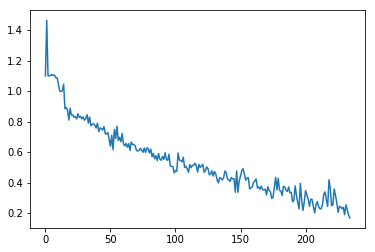

In [22]:
import matplotlib.pyplot as plt
x_axis = range(0,len(train_losses))
plt.plot(x_axis,train_losses)